# Genre Classification using IMDb movie summaries

## Problem Description 
Movie genres play an important role both in determining the likelihood of a potential viewer to watch the movie and to find it interesting. It is difficult to know the genre of every movie as there are thousands of movies releasing every year. If users want to find the genre of a movie, they have to manually go through the process of finding the genre tags from the IMDb webpage of the movie. It is not possible to figure out the genre of a movie from a simple summary. 
 
Therefore, we aim to develop a model which predicts the movie genre using IMDb movie summaries. It eliminates the manual process of finding genre tags. As a plot summary conveys much information about a movie, we explore different neural network models to predict the movie genre using movie summaries.

**Note**: 
- Model checkpoints for MLP, CNN, RNN along with the dataset are here: https://drive.google.com/drive/folders/161h1DmINy-jpUCMJu-9U1ZrylukOMZYx?usp=sharing

- `data_scraper.py` is our custom scraper used to extract IMDb data.

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns

from tqdm import tqdm
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

## 1. Load data into a Pandas Dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder_path = '/content/drive/MyDrive/NN_Project/'
file_path= 'data/collected_imdb.csv'
movies = pd.read_csv(folder_path+file_path, index_col=0)
movies.head()

,movie,genre,summary,labelled_genre
0,Black Panther: Wakanda Forever,"Action,Adventure,Drama",The people of Wakanda fight to protect their h...,A
1,Enola Holmes 2,"Action,Adventure,Crime","Now a detective-for-hire, Enola Holmes takes o...",A
2,Weird: The Al Yankovic Story,"Biography,Comedy,Music","Explores every facet of Yankovic's life, from ...",B
3,The Whale,Drama,A reclusive English teacher attempts to reconn...,D
4,Don't Worry Darling,"Drama,Thriller",A 1950s housewife living with her husband in a...,D


In [ ]:
movies.describe()

,movie,genre,summary,labelled_genre
count,117460,117460,117460,117460
unique,67265,1401,70142,36
top,The Three Musketeers,Drama,Add a Plot,Comedy
freq,34,5290,4056,20503


### Observations
- Only ~67k out of ~117 million movies are unique. Hence, we remove duplicate movies.
- The most frequent summary is `Add a Plot`. These movies don't have any summaries and hence, need to be discarded.
- `labelled_genre` is extremely diverse and needs to be standardized.

In [ ]:
movies=movies.drop_duplicates(subset='movie')
movies = movies[movies["summary"].str.contains("Add a Plot") == False]
movies = movies.reset_index(drop=True)
movies

,movie,genre,summary,labelled_genre
0,Black Panther: Wakanda Forever,"Action,Adventure,Drama",The people of Wakanda fight to protect their h...,A
1,Enola Holmes 2,"Action,Adventure,Crime","Now a detective-for-hire, Enola Holmes takes o...",A
2,Weird: The Al Yankovic Story,"Biography,Comedy,Music","Explores every facet of Yankovic's life, from ...",B
3,The Whale,Drama,A reclusive English teacher attempts to reconn...,D
4,Don't Worry Darling,"Drama,Thriller",A 1950s housewife living with her husband in a...,D
...,...,...,...,...
64009,The EBay Pickup,"Documentary,Short,Action","After winning a bid on EBay, Pat travels far f...",Sci-Fi
64010,Underland Episode III: Beyond the Rift,"Action,Adventure,Comedy",UNDERLAND' takes us along for the journey of a...,Sci-Fi
64011,The Turtle and the Time Machine,"Comedy,Drama,Sci-Fi",Three 20-somethings roam the Tennessee country...,Sci-Fi
64012,Form Function,"Documentary,Short,Sci-Fi",This purely visual short film shows an industr...,Sci-Fi


## 2. Data Preprocessing

### A. The summaries are cleaned by:
   
1. removing any `\`, `'`, or trailing whitespace
2. keeping only lower-case alphabets

In [ ]:
def clean_dataset(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [ ]:
movies['clean_summary'] = movies['summary'].apply(lambda x: clean_dataset(x))
movies.head(5)

,movie,genre,summary,labelled_genre,clean_summary
0,Black Panther: Wakanda Forever,"Action,Adventure,Drama",The people of Wakanda fight to protect their h...,A,the people of wakanda fight to protect their h...
1,Enola Holmes 2,"Action,Adventure,Crime","Now a detective-for-hire, Enola Holmes takes o...",A,now a detective for hire enola holmes takes on...
2,Weird: The Al Yankovic Story,"Biography,Comedy,Music","Explores every facet of Yankovic's life, from ...",B,explores every facet of yankovics life from hi...
3,The Whale,Drama,A reclusive English teacher attempts to reconn...,D,a reclusive english teacher attempts to reconn...
4,Don't Worry Darling,"Drama,Thriller",A 1950s housewife living with her husband in a...,D,a s housewife living with her husband in a uto...


In [ ]:
del movies['summary']

### B. Most frequent words in summaries

We plot the frequency of the most frequently occuring words in the summaries. We observe that:
1. Words such as `the`, `a`, `and`, `to`, etc.(stopwords) occupy approximately the first 50 most frequent words.
2. The word-frequency distribution is heavily skewed due to these stopwords. Therefore, a model trained on these summaries will give more importance to them, over actual genre-defining words. This will lead to noisy predictions.

In [ ]:
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 

    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 

    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

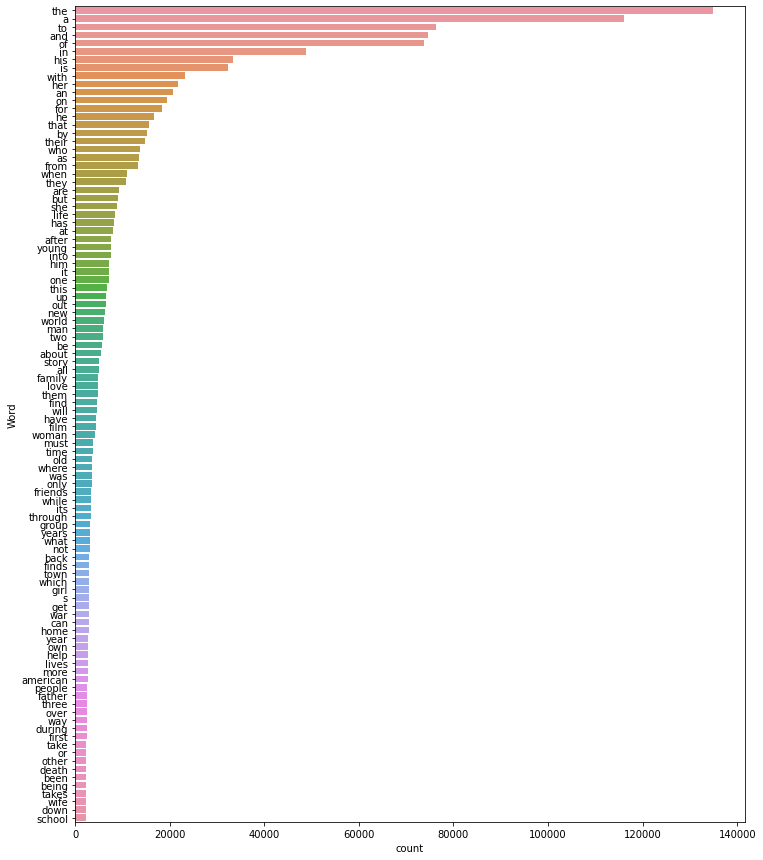

In [ ]:
freq_words(movies['clean_summary'], 100)

### C. Removal of stopwords, stemming in summaries

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movies['clean_summary'] = movies['clean_summary'].apply(lambda x: remove_stopwords(x))

movies['stemmed_summary'] = movies['clean_summary'].str.split()
movies['stemmed_summary'] = movies['stemmed_summary'].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
movies['stemmed_summary'] = movies['stemmed_summary'].apply(lambda x: ' '.join(x))
movies

,movie,genre,labelled_genre,clean_summary,stemmed_summary
0,Black Panther: Wakanda Forever,"Action,Adventure,Drama",A,people wakanda fight protect home intervening ...,peopl wakanda fight protect home interven worl...
1,Enola Holmes 2,"Action,Adventure,Crime",A,detective hire enola holmes takes first offici...,detect hire enola holm take first offici case ...
2,Weird: The Al Yankovic Story,"Biography,Comedy,Music",B,explores every facet yankovics life meteoric r...,explor everi facet yankov life meteor rise fam...
3,The Whale,Drama,D,reclusive english teacher attempts reconnect e...,reclus english teacher attempt reconnect estra...
4,Don't Worry Darling,"Drama,Thriller",D,housewife living husband utopian experimental ...,housewif live husband utopian experiment commu...
...,...,...,...,...,...
64009,The EBay Pickup,"Documentary,Short,Action",Sci-Fi,winning bid ebay pat travels far home pick unu...,win bid ebay pat travel far home pick unusu it...
64010,Underland Episode III: Beyond the Rift,"Action,Adventure,Comedy",Sci-Fi,underland takes us along journey young girl th...,underland take us along journey young girl thr...
64011,The Turtle and the Time Machine,"Comedy,Drama,Sci-Fi",Sci-Fi,three somethings roam tennessee countryside se...,three someth roam tennesse countrysid search t...
64012,Form Function,"Documentary,Short,Sci-Fi",Sci-Fi,purely visual short film shows industrial desi...,pure visual short film show industri design cr...


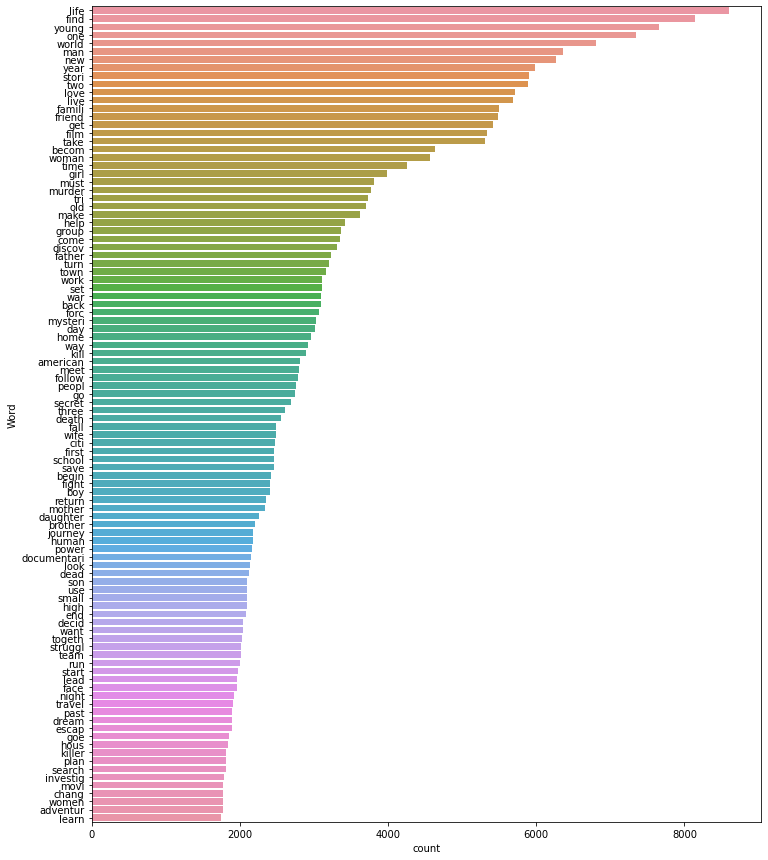

In [ ]:
movies['summary'] = movies['stemmed_summary']
del movies['clean_summary']
del movies['stemmed_summary']
freq_words(movies['summary'], 100)

In [ ]:
movies["Number of Words"] = movies["summary"].apply(lambda n: len(n.split()))
movies['Number of Words'].describe()

count    64014.000000
mean        22.236042
std         20.181776
min          1.000000
25%         12.000000
50%         17.000000
75%         23.000000
max        612.000000
Name: Number of Words, dtype: float64

### Observations:
1. After removal of stopwords, more significant words such as `life`, `world`, `love`, `family`, `documentary` will get attention from the models to predict genre.
2. Each word is stemmed into their base-form to standardize the data without losing its overall meaning. This reduces noisyness (unneccesary variance) in the data even when the meaning is essentially the same. For e.g.:
    - `takes` and `taken` becomes `take`.
    - `running`, `run`, `ran` becomes `run`. 
3. The frequency distribution is highly uniform after the first top 10 words, thereby reducing bias.
4. Each summary is of variable length. The maximum number of words in a summary is `612`, whereas 75% of the summaries are `23` words or less. Hence, we can safely assume `~25` features in each summary without losing generality.

### D. Preprocessing labels

In [ ]:
movies['labelled_genre'] = movies['genre'].str.split(',')
movies['labelled_genre'] = movies['labelled_genre'].apply(lambda x: x[0])
movies

,movie,genre,labelled_genre,summary,Number of Words
0,Black Panther: Wakanda Forever,"Action,Adventure,Drama",Action,peopl wakanda fight protect home interven worl...,12
1,Enola Holmes 2,"Action,Adventure,Crime",Action,detect hire enola holm take first offici case ...,21
2,Weird: The Al Yankovic Story,"Biography,Comedy,Music",Biography,explor everi facet yankov life meteor rise fam...,21
3,The Whale,Drama,Drama,reclus english teacher attempt reconnect estra...,8
4,Don't Worry Darling,"Drama,Thriller",Drama,housewif live husband utopian experiment commu...,14
...,...,...,...,...,...
64009,The EBay Pickup,"Documentary,Short,Action",Documentary,win bid ebay pat travel far home pick unusu it...,11
64010,Underland Episode III: Beyond the Rift,"Action,Adventure,Comedy",Action,underland take us along journey young girl thr...,24
64011,The Turtle and the Time Machine,"Comedy,Drama,Sci-Fi",Comedy,three someth roam tennesse countrysid search t...,8
64012,Form Function,"Documentary,Short,Sci-Fi",Documentary,pure visual short film show industri design cr...,15


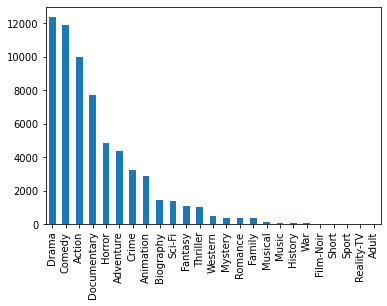

In [ ]:
movies.labelled_genre.value_counts().plot(kind = 'bar')

### Observations:
1. Each movie was assigned the first label in the `genre` column. There are a total of 25 genres with unequal distribution across the dataset.
2. We select the top 5 main genres as our final labels `(Y)` and map the other genres to these 5 in either of the 2 ways:
    - For each movie, loop over the `genre` column and assign it the first genre which belongs to `Y`.
    - If none of the genres belong to `Y`, use the `genre_map` dictionary to manually assign it a label from `Y`.
3. This helps to create a focussed and uniform dataset by having broader categories and lesser noise (as the movies with genres like `Sport`, `Adult` won't have correct predictions anyway due to very less data).

In [ ]:
interested = ['Drama', 'Comedy', 'Action', 'Documentary', 'Horror']
genre_map = {
    'Adventure': 'Action', 
    'Biography': 'Documentary',
    'Crime': 'Action',
    'Animation': 'Drama',
    'Thriller': 'Horror',
    'Western': 'Drama',
    'Romance': 'Drama',
    'Fantasy': 'Horror',
    'Sci-Fi': 'Action',
    'Mystery': 'Horror',
    'Family': 'Drama',
    'Musical': 'Comedy',
    'Music': 'Comedy',
    'History': 'Documentary',
    'War': 'Action',
    'Film-Noir': 'Action',
    'Sport': 'Action',
    'Short': 'Drama',
    'Reality-TV': 'Documentary',
    'Adult': 'Comedy'
    }
new_genres = []

for row in movies['genre'].str.split(','):
    flag=0
    for genre in row:
        if genre in interested:
            new_genres.append(genre)
            flag=1
            break
    if flag == 0:
        new_genres.append(genre_map[row[0]])
        
movies['new_genre'] = new_genres
movies

,movie,genre,labelled_genre,summary,Number of Words,new_genre
0,Black Panther: Wakanda Forever,"Action,Adventure,Drama",Action,peopl wakanda fight protect home interven worl...,12,Action
1,Enola Holmes 2,"Action,Adventure,Crime",Action,detect hire enola holm take first offici case ...,21,Action
2,Weird: The Al Yankovic Story,"Biography,Comedy,Music",Biography,explor everi facet yankov life meteor rise fam...,21,Comedy
3,The Whale,Drama,Drama,reclus english teacher attempt reconnect estra...,8,Drama
4,Don't Worry Darling,"Drama,Thriller",Drama,housewif live husband utopian experiment commu...,14,Drama
...,...,...,...,...,...,...
64009,The EBay Pickup,"Documentary,Short,Action",Documentary,win bid ebay pat travel far home pick unusu it...,11,Documentary
64010,Underland Episode III: Beyond the Rift,"Action,Adventure,Comedy",Action,underland take us along journey young girl thr...,24,Action
64011,The Turtle and the Time Machine,"Comedy,Drama,Sci-Fi",Comedy,three someth roam tennesse countrysid search t...,8,Comedy
64012,Form Function,"Documentary,Short,Sci-Fi",Documentary,pure visual short film show industri design cr...,15,Documentary


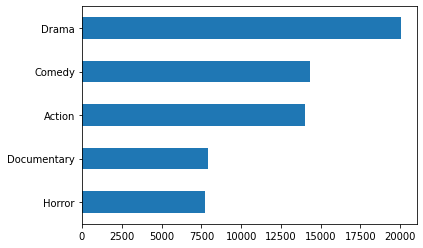

In [ ]:
movies.new_genre.value_counts().sort_values().plot(kind = 'barh')

In [ ]:
movies['labelled_genre'] = movies['new_genre']
del movies['new_genre']
del[movies['Number of Words']]
movies.to_csv(folder_path+'data/cleaned_imdb.csv')

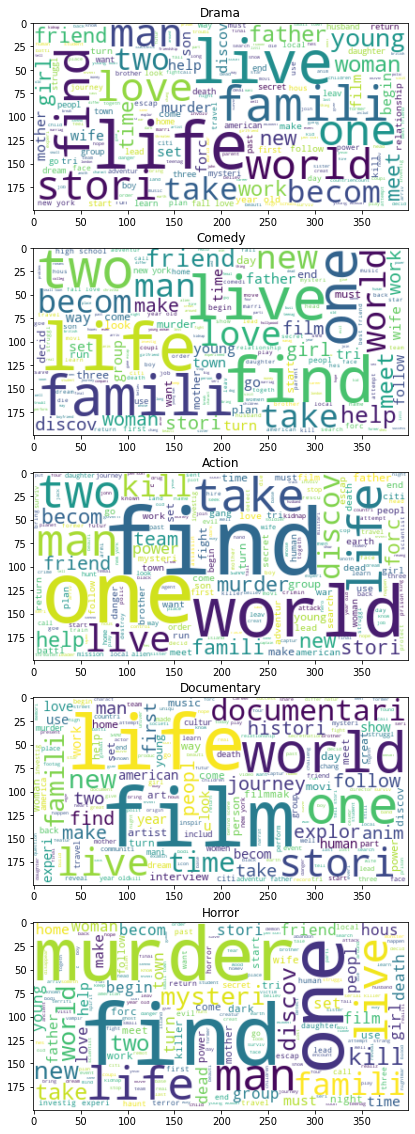

In [ ]:
fig, ax = plt.subplots(5, figsize=(20, 20))
i = 0

for genre in interested:
    summary = movies[movies.labelled_genre == genre]['summary']
    text = " ".join(i for i in summary)
    wordcloud = WordCloud(background_color="white").generate(text)
    ax[i].set_title(genre)
    ax[i].imshow(wordcloud, interpolation='bilinear')
    i += 1

### Observations:
1. We create wordclouds for each of our 5 label genres. Following observations from each wordcloud shows the correlation of summaries to its respective genres:
- Drama: `live, love, life, family, story`
- Comedy: `live, love, find, family`
- Action: `kill, gang, power, murder, world, help`
- Documentary: `film, life, documentary, person, people, journey`
- Horror: `murder, mysteri, kill, dead, force, man`

As is intuitive, these words do give an idea about the genre of a movie solely from its meaning.

2. However, it is to note that `Drama` and `Comedy` have very similar wordclouds. Also, `Action` and `Horror` are correlated. Hence, it is possible that the neural networks are not able to differentiate between these 2 pairs very well, thereby leading to incorrect predictions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

folder_path = '/content/drive/MyDrive/NN_Project/'
!ls /content/drive/MyDrive/NN_Project/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
 cnn_model.pt		    gru_new.py	       README.md
 data			    mlp_model.pt       requirements.txt
 data_scraper.py	    non_recurrent.py   rnn_model.pt
 data_visualization.ipynb  'Old trial'


# Evaluation of Deep Learning Models

In [ ]:
import argparse
import datetime
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

## Load data
The final data after cleaning and visualization is loaded onto a Pandas dataframe. Out of all the columns, `summaries` is our training text and `labelled_genre` are our labels.

In [ ]:
if torch.cuda.is_available():
    device_str = 'cuda:{}'.format(0)
else:
    device_str = 'cpu'
device = torch.device(device_str)
print('device:', device)
cpu = torch.device('cpu')

from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/NN_Project/'
file_path= 'data/collected_imdb.csv'

data_path = folder_path + 'data/cleaned_imdb.csv'
movies = pd.read_csv(data_path, index_col=0)
data = movies[['summary', 'labelled_genre']]

device: cuda:0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocess text summaries

## Tokenize sentences:
  - For each summary in training data, split the summaries into individual words (tokens). This creates the vocabulary of the training set.
  - Use the top N (`max_features`) tokens from the vocabulary and convert them into text embeddings, i.e., from text to number mapping.
  - Fit the training and test data with these text embeddings. Therefore, 
    - each summary would be a sequence of embedded token. 
    - all words that are not a part of the N text embeddings would be ignored.
    - the vocab size of the training data would be limited to N.
  - Labels are tokenized in a similar way. The text labels are mapped to a corresponsing number. E.g., `Action` --> `0`, `Drama` --> `1`, etc.

## Pad sequences
Since summaries of all movies are of variable length, we pad all the summaries to `max_len`. This results in the following:
  - if `len(summary) < max_len`, then `0`s are appended at the end.
  - if  `len(summary) > max_len`, then the summary is truncated.

This makes all the summaries of equal length. Since the architecture (no. of neurons in the input layer) of a neural network is constant, the padded texts can now be used as their input.

In [ ]:
def process_texts(train_X, test_X, max_features, max_len):
    # Create tokenizer
    tokenizer = Tokenizer(num_words = max_features)
    tokenizer.fit_on_texts(list(train_X))

    # Tokenize the words in the training and test summaries
    train_X = tokenizer.texts_to_sequences(train_X)
    test_X = tokenizer.texts_to_sequences(test_X)

    # Pad the tokenized arrays 
    train_X = pad_sequences(train_X, maxlen = max_len)
    test_X = pad_sequences(test_X, maxlen = max_len)

    return train_X, test_X, tokenizer

In [ ]:
def process_labels(train_Y, test_Y):
    encoder = LabelEncoder()
    train_Y = encoder.fit_transform(train_Y.values)
    test_Y = encoder.transform(test_Y.values)
    return train_Y, test_Y, encoder

# Multilayer Perceptron

### Motivation
We use multilayer neural network when dealing with datasets which need more model complexity and capacity. Neural Networks help us extract more complex and meaninful insights or features when compared to statistical methods. We set a simple MLP of 4 layers as our baseline. 

1. **It is a fully connected layer which means that all the features are related to each other.** Because of this, the number of trainable parameters are high resulting in a computationally intensive model for most simple tasks.

### Architecture

- We transform tokens into linear space (called embeddings) to get a feature representation of all the tokens we have in our training set vocabulary.**This helps us learn correlations between the words in the summaries.** This is used as inputs to all of our neural networks. 

- We use Adam as our optimizer since it is able to surpass local minimas in lesser number of epochs. We also use a small learning rate in order to keep Adam's learning stabilized. 

```
Tokenized batch input 
    -> Embeddings
        -> Linear -> Tanh
            -> Linear -> Dropout -> Tanh
                -> Linear -> Dropout -> Tanh
                    -> Linear -> Dropout -> Tanh
                        -> Softmax                      
```


In [ ]:
class MLP_Model(nn.Module):

    def __init__(self, num_classes, max_features, embedding_dim, max_len, device='cpu'):
        super(MLP_Model, self).__init__()
        neuron_sizes = [(max_len*embedding_dim, 1000), (1000, 500), (500, 250), (250, num_classes)]
        self.train_accuracies, self.val_accuracies = [], []
        self.train_losses, self.val_losses = [], []

        self.embedding = nn.Embedding(max_features, embedding_dim, padding_idx=0)
        self.linears = nn.ModuleList([nn.Linear(in_f, out_f).to(device) for (in_f, out_f) in neuron_sizes])
        self.dropout = nn.Dropout(0.25)
        self.flatten = nn.Flatten(-2, -1)

    def forward(self, inputs):
        x = self.embedding(inputs)
        x = self.flatten(x)
        for layer in self.linears:
            if x.shape[1] < 1000:
                x = torch.tanh(self.dropout(layer(x)))
            else:
                x = torch.tanh(layer(x))
        outputs = x

        return outputs

In [ ]:
def non_recurrent_train(model, train_X, train_Y, test_X, test_Y, tokenizer, encoder, batch_size, learning_rate, num_epochs, device='cpu', model_path=None):

    train_X = torch.tensor(train_X, dtype=torch.long).to(device)
    train_Y = torch.tensor(train_Y, dtype=torch.long).to(device)
    test_X = torch.tensor(test_X, dtype=torch.long).to(device)
    test_Y = torch.tensor(test_Y, dtype=torch.long).to(device)
    train_dataset = torch.utils.data.TensorDataset(train_X, train_Y)
    test_dataset = torch.utils.data.TensorDataset(test_X, test_Y)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss(reduction='sum')
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train_accuracies, model.train_losses = [], []
    model.val_accuracies, model.val_losses = [], []

    start = datetime.datetime.now()
    print("Training started at: ", start)

    for epoch in range(num_epochs):
        model.train(True)
        running_loss = 0.0
        true_count, total_count, accuracies = 0, 0, []

        for step, data in enumerate(train_loader):
            # get the inputs; data is a tuple of (inputs, labels)
            texts = data[0].to(device)
            labels = data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            # do forward propagation
            probabilities = model(texts)
            # do loss calculation
            loss = criterion(probabilities, labels)
            # do backward propagation
            loss.backward()
            # do parameter optimization step
            optimizer.step()

             # Calculate the count of accurate predictions
            true_count += torch.sum(torch.argmax(probabilities, dim=1) == labels)
            total_count += labels.shape[0]

            # calculate running loss value for non padding
            running_loss += loss.item()
            avg_loss = running_loss / (step + 1)
            accuracy = (true_count/total_count)*100
            accuracies.append(accuracy)

            if (step+1)%100 == 0:
                print('epoch: {}, step: {}, loss: {},accuracy: {}'.format(epoch+1, step+1, avg_loss, accuracy))
        model.train_accuracies.append(sum(accuracies)*1.0/len(accuracies))
        model.train_losses.append(avg_loss)
        
        # Turn off model training for validation
        model.eval()
        running_vloss = 0.0
        true_count = 0
        total_count = 0
        
        for step, vdata in enumerate(validation_loader):
            
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)

            # Use the current model to get outputs for the validation inputs
            voutputs = model(vinputs)

            # Get the validation loss
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss

            # Calculate the count of accurate predictions
            true_count += torch.sum(torch.argmax(voutputs, dim=1) == vlabels)
            total_count += vlabels.shape[0]

        # Calculate average loss over all steps
        avg_vloss = running_vloss / (step + 1)
        accuracy = (true_count/total_count)*100
        model.val_accuracies.append(accuracy)
        model.val_losses.append(avg_vloss)
        print(f'validation, epoch: {epoch+1}, loss: {avg_vloss}, accuracy: {(true_count/total_count)*100}')

    model.val_accuracies = torch.Tensor(model.val_accuracies).to(cpu)
    model.val_losses = torch.Tensor(model.val_losses).to(cpu)
    model.train_accuracies = torch.Tensor(model.train_accuracies).to(cpu)
    model.train_losses = torch.Tensor(model.train_losses).to(cpu)
    end = datetime.datetime.now()
    print("Training ended at: ", end)
    
    # define the checkpoint and save it to the model path
    # tip: the checkpoint can contain more than just the model
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
        'vocabulary': {
            'texts': list(tokenizer.word_index.keys()),
            'labels': list(encoder.classes_)
        }
    }
    torch.save(checkpoint, model_path)

    print('Model saved in ', model_path)
    print('Training finished in {} minutes.'.format((end - start).seconds / 60.0))
    

In [ ]:
learning_rate = 1e-3
batch_size = 200
num_epochs = 20
max_features = 7000
max_len = 100
embedding_dim = 32

train_X, test_X, train_Y, test_Y = train_test_split(data['summary'], data['labelled_genre'], 
                                                  stratify=data['labelled_genre'], test_size = 0.2)
train_X, test_X, tokenizer = process_texts(train_X, test_X, max_features, max_len)
train_Y, test_Y, encoder = process_labels(train_Y, test_Y)
num_classes = len(encoder.classes_)

mlp_model = MLP_Model(num_classes, max_features, embedding_dim, max_len, device_str).to(device)
non_recurrent_train(mlp_model, train_X, train_Y, test_X, test_Y, tokenizer, encoder, batch_size, learning_rate, num_epochs, device, folder_path+'mlp_model.pt')

Training started at:  2022-11-15 15:01:22.792561
epoch: 1, step: 100, loss: 317.69242889404296,accuracy: 26.760000228881836
epoch: 1, step: 200, loss: 315.13740951538085,accuracy: 27.677499771118164
validation, epoch: 1, loss: 304.55303955078125, accuracy: 30.61001205444336
epoch: 2, step: 100, loss: 306.39094512939454,accuracy: 31.34000015258789
epoch: 2, step: 200, loss: 306.0530972290039,accuracy: 31.25
validation, epoch: 2, loss: 300.2711181640625, accuracy: 31.35983657836914
epoch: 3, step: 100, loss: 297.36325927734373,accuracy: 35.165000915527344
epoch: 3, step: 200, loss: 298.3504066467285,accuracy: 34.54499816894531
validation, epoch: 3, loss: 294.8927001953125, accuracy: 32.953216552734375
epoch: 4, step: 100, loss: 289.22502197265624,accuracy: 38.220001220703125
epoch: 4, step: 200, loss: 290.22788208007813,accuracy: 37.75
validation, epoch: 4, loss: 295.050537109375, accuracy: 34.530967712402344
epoch: 5, step: 100, loss: 282.54746826171873,accuracy: 40.95000076293945
epoch

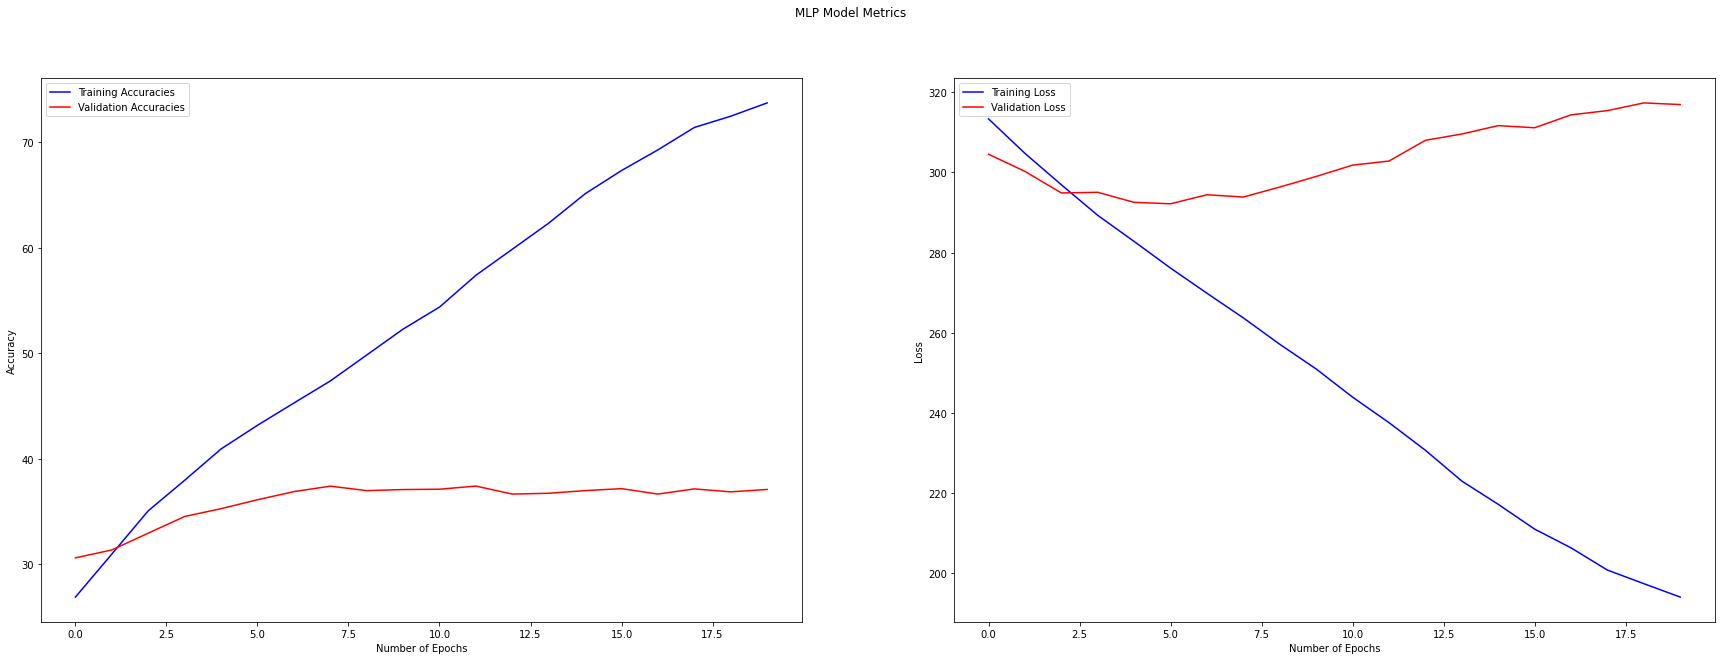

In [ ]:
# Plotting the accuracy and loss of the MLP model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
plt.suptitle('MLP Model Metrics')
ax1.plot(np.arange(len(mlp_model.train_accuracies)), mlp_model.train_accuracies, 'b-', label='Training Accuracy')
ax1.plot(torch.arange(len(mlp_model.val_accuracies)), mlp_model.val_accuracies, 'r-', label='Validation Accuracy')
ax1.set_xlabel('Number of Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(torch.arange(len(mlp_model.train_losses)), mlp_model.train_losses, 'b-', label='Training Loss')
ax2.plot(torch.arange(len(mlp_model.val_losses)), mlp_model.val_losses, 'r-', label='Validation Loss')
ax2.set_xlabel('Number of Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
plt.show()

## Analysis

From the graphs, we see that:
- the training accuracy keeps increasing while the validation accuracy stagnates at 37%. 
-  the training loss keeps decreasing while the validation loss decreases initially and then increases steadily.

1. This trend shows that our model starts to overfit after epoch 8, and hence under-performs on the validation set. 
2. We implemented multiple regularization techniques such as dropout in all layers (except the input), more data (scaled from 27k to 64k movies), and performed hyperparamater-tuning. Since an MLP treats all features to be dependent on each other, it doesn't give very high accuracy.

# Convolutional Neural Network

## Motivation for Architecture

1. Similar words will have similar embeddings and a convolution operation is a linear operation on these vectors. So, when a convolutional kernel is applied to different sets of similar words, it will produce a similar output value. **Hence, movies of same genres may contain similar words, thereby producing similar convolutional outputs leading to the same class.**

2. In the case of text classification, a convolutional kernel is a sliding window used to look at sequences of word embeddings. ** It is designed to capture local features of sequential words.**

3. If we see the phrase `biography of Gandhi`, it is a good indicator that this belongs to the genre `Documentary`, no matter its location in the source text. **Hence, we do the maxpooling operation which forces the network to retain only the maximum value in a feature vector, which should be the most useful, local feature.**

4. The max-values produced by processing each of the convolutional feature vectors will be concatenated and passed to a final, fully-connected layer that can produce as many class scores as our task requires.

### Architecture

1. We perform convolution using 4 kernel sizes to observe 4 `n-grams` and concatenate their outputs together to get maximum information about local spatial features. i.e., we look at unigrams, bigrams, trigrams and pentagrams.

2. We use `Conv2d` without flattening the embedded torch tensor instead of `Conv1d + Flatten`. It is essentially the same in meaning, i.e., it slides over multiple neighbouring words (sequential phrases) to get local context of the summaries.

```
Tokenized batch input -> Embeddings
                         -> Conv2d (1*1) -> Tanh -> maxPool = a
                         -> Conv2d (2*2) -> Tanh -> maxPool = b
                         -> Conv2d (3*3) -> Tanh -> maxPool = c
                         -> Conv2d (5*5) -> Tanh -> maxPool = d
                                    -> concat(a,b,c,d) -> Dropout
                                                              -> Linear -> Softmax                      
```



In [ ]:
class CNN_Model(nn.Module):
    
    def __init__(self, num_classes, max_features, embedding_dim, device='cpu'):
        super(CNN_Model, self).__init__()
        kernel_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = num_classes
        self.train_accuracies, self.val_accuracies = [], []
        self.train_losses, self.val_losses = [],  []

        self.embedding = nn.Embedding(max_features, embedding_dim, padding_idx=0)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embedding_dim)).to(device) for K in kernel_sizes])
        self.dropout = nn.Dropout(0.7)
        self.linear = nn.Linear(len(kernel_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  
        x = [torch.tanh(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        outputs = self.linear(x) 
        return outputs

In [ ]:
learning_rate = 1e-3
batch_size = 200
num_epochs = 20
max_features = 7000
max_len = 25
embedding_dim = 32

train_X, test_X, train_Y, test_Y = train_test_split(data['summary'], data['labelled_genre'], 
                                                stratify=data['labelled_genre'], test_size = 0.2)
train_X, test_X, tokenizer = process_texts(train_X, test_X, max_features, max_len)
train_Y, test_Y, encoder = process_labels(train_Y, test_Y)
num_classes = len(encoder.classes_)
cnn_model = CNN_Model(num_classes, max_features, embedding_dim, device_str).to(device)

non_recurrent_train(cnn_model, train_X, train_Y, test_X, test_Y, tokenizer, encoder, batch_size, learning_rate, num_epochs, device, folder_path+'cnn_model.pt')

Training started at:  2022-11-15 15:16:27.080301
epoch: 1, step: 100, loss: 330.1927847290039,accuracy: 25.90999984741211
epoch: 1, step: 200, loss: 322.32718490600587,accuracy: 27.399999618530273
validation, epoch: 1, loss: 302.5185852050781, accuracy: 31.297353744506836
epoch: 2, step: 100, loss: 309.0202615356445,accuracy: 31.05999755859375
epoch: 2, step: 200, loss: 308.81283248901366,accuracy: 30.984996795654297
validation, epoch: 2, loss: 298.8907470703125, accuracy: 31.492618560791016
epoch: 3, step: 100, loss: 305.2719976806641,accuracy: 31.794998168945312
epoch: 3, step: 200, loss: 303.8998471069336,accuracy: 32.1875
validation, epoch: 3, loss: 291.2957458496094, accuracy: 34.78091049194336
epoch: 4, step: 100, loss: 296.4202914428711,accuracy: 34.439998626708984
epoch: 4, step: 200, loss: 295.4490821838379,accuracy: 34.82500076293945
validation, epoch: 4, loss: 283.8569030761719, accuracy: 36.85854721069336
epoch: 5, step: 100, loss: 289.2712213134766,accuracy: 36.70499801635

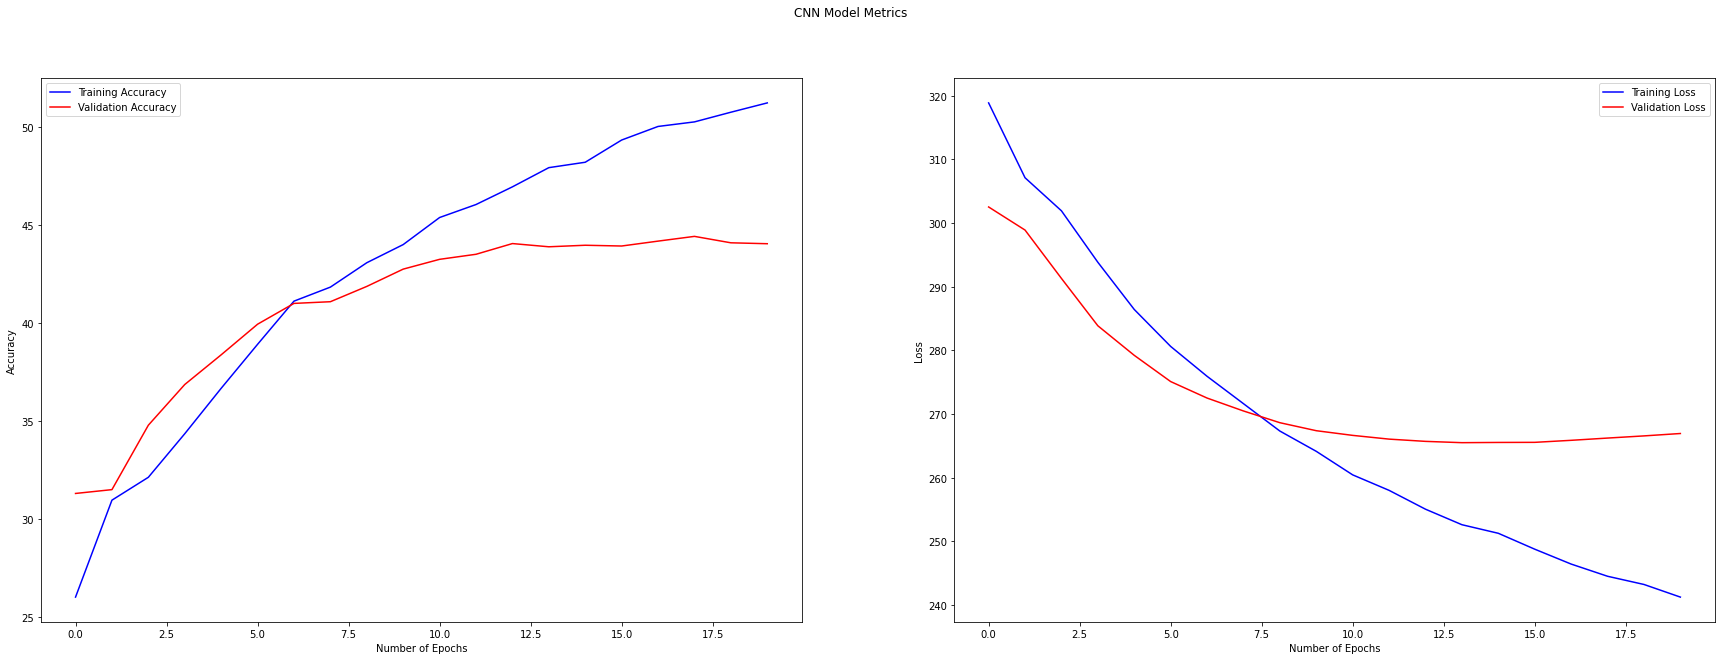

In [ ]:
# Plotting the accuracy and loss of the CNN model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
plt.suptitle('CNN Model Metrics')
ax1.plot(torch.arange(len(cnn_model.train_accuracies)), cnn_model.train_accuracies.to(cpu), 'b-', label='Training Accuracy')
ax1.plot(torch.arange(len(cnn_model.val_accuracies)), cnn_model.val_accuracies.to(cpu), 'r-', label='Validation Accuracy')
ax1.set_xlabel('Number of Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(torch.arange(len(cnn_model.train_losses)), cnn_model.train_losses.to(cpu), 'b-', label='Training Loss')
ax2.plot(torch.arange(len(cnn_model.val_losses)), cnn_model.val_losses.to(cpu), 'r-', label='Validation Loss')
ax2.set_xlabel('Number of Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
plt.show()

## Analysis

From the graphs, we see that:
- the training accuracy keeps increasing while the validation accuracy stagnates at 44%. 
-  the training loss keeps decreasing while the validation loss decreases and then stagnates around 270.

1. This trend shows that our model starts to overfit after epoch 12, and hence under-performs on the validation set. **This means that model training has diverged.**

2. We implemented multiple regularization techniques such as dropout in the linear layer, more data (scaled from 27k to 64k movies), and performed hyperparamater-tuning. 

3. In this CNN, we implement the concept of n-grams followed by maxPool to understand the most important spatial features.**Therefore, each feature vector is given more context instead of blindly relating all words to each other.**

**Hence, it performs better than our baseline.**

# Long-Short Term Memory Network

## Motivation for architecture

In LSTMs, the relevant information is kept and all the irrelevant information gets discarded in every single cell. It has 3 main gates.

1. **FORGET Gate:** Information from the previous hidden state along with information in the current cell decide whether it should be discarded.

2. **INPUT Gate:** Input Gate updates the cell state and decides which information is important and store it in the memory that relevant.

3. **OUTPUT Gate:** It decides what the next hidden state should be. 

**LSTM has the advantage of remembering context in long text sequences, thereby extracting enough relevant information from each movie summaries.**

## Architecture

Multiple specifications are listed below:

1. We use bidirectional LSTMs in order to learn the reverse word dependencies as well. Moreover, only the last element of the output of an LSTM is required sicne it contains all the previous data encoded within itself.

2. We experimented with number of stacked LSTMs from 2 to 10. `3` gives the best results. Stacking provides more depth to the network, thereby allowing more features to be learnt. 

3. the weights of the LSTM are initialized using a uniform distribution. Additonally, we normalize the gradient after every epoch to avoid the vanishing gradient problem.

4. Multiple methods are used to regularize learning such as high dropout, exponential learning rate scheduler, and larger vocabulary size.

```
Tokenized batch input 
    -> Embeddings
        -> Bidirectional LSTM
            -> Bidirectional LSTM
                -> Bidirectional LSTM
                    -> Last output -> Softmax                      
```


In [ ]:
class RNN_Model(nn.Module):
    def __init__(self, num_classes, max_features, embedding_dim, hidden_size=128, device='cpu'):
        super(RNN_Model, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_dim = embedding_dim
        self.num_layers = 3
        self.train_accuracies, self.val_accuracies = [], []
        self.train_losses, self.val_losses = [], []

        self.embedding = nn.Embedding(max_features, self.embedding_dim, padding_idx=0)
        self.dropout = nn.Dropout(0.35)
        self.rnn = nn.LSTM(self.embedding_dim, self.hidden_size, num_layers=self.num_layers, bidirectional=True, dropout=0.6)
        self.output = nn.Linear(self.hidden_size*2, num_classes)

    def forward(self, word_seq, h_init):
        embedded = self.embedding(word_seq)
        embedded = torch.transpose(embedded, 0, 1)

        h_seq, h_final = self.rnn(embedded, h_init)
        score_seq = torch.tanh(self.dropout(self.output(h_seq)))

        return score_seq[-1], h_final

In [ ]:
def normalize_gradient(model):
    norm_sq=0

    for param in model.parameters():
        norm_sq += param.grad.data.norm() ** 2
    grad_norm=torch.sqrt(norm_sq)

    if grad_norm<1e-4:
        model.zero_grad()
    else:    
        for param in model.parameters():
            param.grad.data.div_(grad_norm)

    return grad_norm

In [ ]:
def recurrent_train(model, train_X, train_Y, test_X, test_Y, tokenizer, encoder, batch_size, learning_rate, num_epochs, device='cpu', model_path=None):

    train_X = torch.tensor(train_X, dtype=torch.long).to(device)
    train_Y = torch.tensor(train_Y, dtype=torch.long).to(device)
    test_X = torch.tensor(test_X, dtype=torch.long).to(device)
    test_Y = torch.tensor(test_Y, dtype=torch.long).to(device)
    train_dataset = torch.utils.data.TensorDataset(train_X, train_Y)
    test_dataset = torch.utils.data.TensorDataset(test_X, test_Y)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # assign these variables
    criterion = nn.CrossEntropyLoss(reduction='sum')
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    # scheduler = optim.lr_scheduler.LinearLR(optimizer)
    h = torch.zeros(model.num_layers*2, batch_size, model.hidden_size).to(device)
    c = torch.zeros(model.num_layers*2, batch_size, model.hidden_size).to(device)
    model.train_accuracies, model.train_losses = [], []
    model.val_accuracies, model.val_losses = [], []

    start = datetime.datetime.now()
    print("Training started at: ", start)

    for epoch in range(num_epochs):
        model.train(True)
        running_loss = 0.0
        true_count = 0
        total_count = 0
        accuracies = []
        for step, data in enumerate(train_loader):
            # get the inputs; data is a tuple of (inputs, labels)
            texts = data[0].to(device)
            labels = data[1].to(device)

            if texts.shape[0] != batch_size:
                continue

            # zero the parameter gradients
            optimizer.zero_grad()
            # do forward propagation
            h = h.detach()
            c = c.detach()
            probabilities, hc = model(texts, (h, c))
            h, c = hc
            # do loss calculation
            loss = criterion(probabilities, labels)
            # do backward propagation
            loss.backward()
            # do parameter optimization step
            normalize_gradient(model)
            optimizer.step()

            # Calculate the count of accurate predictions
            true_count += torch.sum(torch.argmax(probabilities, dim=1) == labels)
            total_count += labels.shape[0]

            # calculate running loss value for non padding
            running_loss += loss.item()
            avg_loss = running_loss / (step + 1)
            accuracy = (true_count/total_count)*100
            accuracies.append(accuracy)
            if (step+1)%50 == 0:
                print('epoch: {}, step: {}, loss: {}, accuracy: {}'.format(epoch+1, step+1, avg_loss, accuracy))
        scheduler.step()
        model.train_accuracies.append((sum(accuracies)*1.0/len(accuracies)))
        model.train_losses.append(avg_loss)
        
        # Turn off model training for validation
        model.eval()
        running_vloss = 0.0
        true_count = 0
        total_count = 0
        h_val = torch.zeros(model.num_layers*2, batch_size, model.hidden_size).to(device)
        c_val = torch.zeros(model.num_layers*2, batch_size, model.hidden_size).to(device)
        for step, vdata in enumerate(validation_loader):
            
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)

            if vinputs.shape[0] != batch_size:
                continue

            # Use the current model to get outputs for the validation inputs
            h_val = h_val.detach()
            c_val = c_val.detach()
            voutputs, hc_val = model(vinputs, (h_val, c_val))
            h_val, c_val = hc_val

            # Get the validation loss
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss

            # Calculate the count of accurate predictions
            true_count += torch.sum(torch.argmax(voutputs, dim=1) == vlabels)
            total_count += vlabels.shape[0]

        # Calculate average loss over all steps
        avg_vloss = running_vloss / (step + 1)
        accuracy = (true_count/total_count)*100
        model.val_accuracies.append(accuracy)
        model.val_losses.append(avg_vloss)
        print(f'validation, epoch: {epoch+1}, loss: {avg_vloss}, accuracy: {accuracy}')

    model.val_accuracies = torch.Tensor(model.val_accuracies).to(cpu)
    model.val_losses = torch.Tensor(model.val_losses).to(cpu)
    model.train_accuracies = torch.Tensor(model.train_accuracies).to(cpu)
    model.train_losses = torch.Tensor(model.train_losses).to(cpu)
    end = datetime.datetime.now()    
    end = datetime.datetime.now()
    print("Training ended at: ", end)
    
    # define the checkpoint and save it to the model path
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
        'vocabulary': {
            'texts': list(tokenizer.word_index.keys()),
            'labels': list(encoder.classes_)
        }
    }
    torch.save(checkpoint, model_path)

    print('Model saved in ', model_path)
    print('Training finished in {} minutes.'.format((end - start).seconds / 60.0))

In [ ]:
learning_rate = 1e-3
batch_size = 600
num_epochs = 20
max_features = 20000
max_len = 25
embedding_dim = 500

train_X, test_X, train_Y, test_Y = train_test_split(data['summary'], data['labelled_genre'], 
                                                    stratify=data['labelled_genre'], test_size = 0.1)

train_X, test_X, tokenizer = process_texts(train_X, test_X, max_features, max_len)
train_Y, test_Y, encoder = process_labels(train_Y, test_Y)
num_classes = len(encoder.classes_)

rnn_model = RNN_Model(num_classes, max_features, embedding_dim, 96, device_str).to(device)
rnn_model.embedding.weight.data.uniform_(-0.1, 0.1)
rnn_model.output.weight.data.uniform_(-0.1, 0.1)

recurrent_train(rnn_model, train_X, train_Y, test_X, test_Y, tokenizer, encoder, batch_size, learning_rate, num_epochs, device,  folder_path+'rnn_model.pt')

Training started at:  2022-11-15 15:27:22.078462
epoch: 1, step: 50, loss: 939.3470581054687, accuracy: 28.62666893005371
validation, epoch: 1, loss: 769.822265625, accuracy: 40.45000076293945
epoch: 2, step: 50, loss: 858.3938720703125, accuracy: 39.349998474121094
validation, epoch: 2, loss: 743.6943969726562, accuracy: 42.04999923706055
epoch: 3, step: 50, loss: 814.6473193359375, accuracy: 43.97999954223633
validation, epoch: 3, loss: 734.3432006835938, accuracy: 44.9666633605957
epoch: 4, step: 50, loss: 776.0755798339844, accuracy: 50.0533332824707
validation, epoch: 4, loss: 739.4124145507812, accuracy: 45.38333511352539
epoch: 5, step: 50, loss: 751.5158508300781, accuracy: 54.02000045776367
validation, epoch: 5, loss: 748.57958984375, accuracy: 45.54999923706055
epoch: 6, step: 50, loss: 730.26455078125, accuracy: 56.86000061035156
validation, epoch: 6, loss: 764.8463745117188, accuracy: 44.650001525878906
epoch: 7, step: 50, loss: 715.1094201660156, accuracy: 58.7066650390625

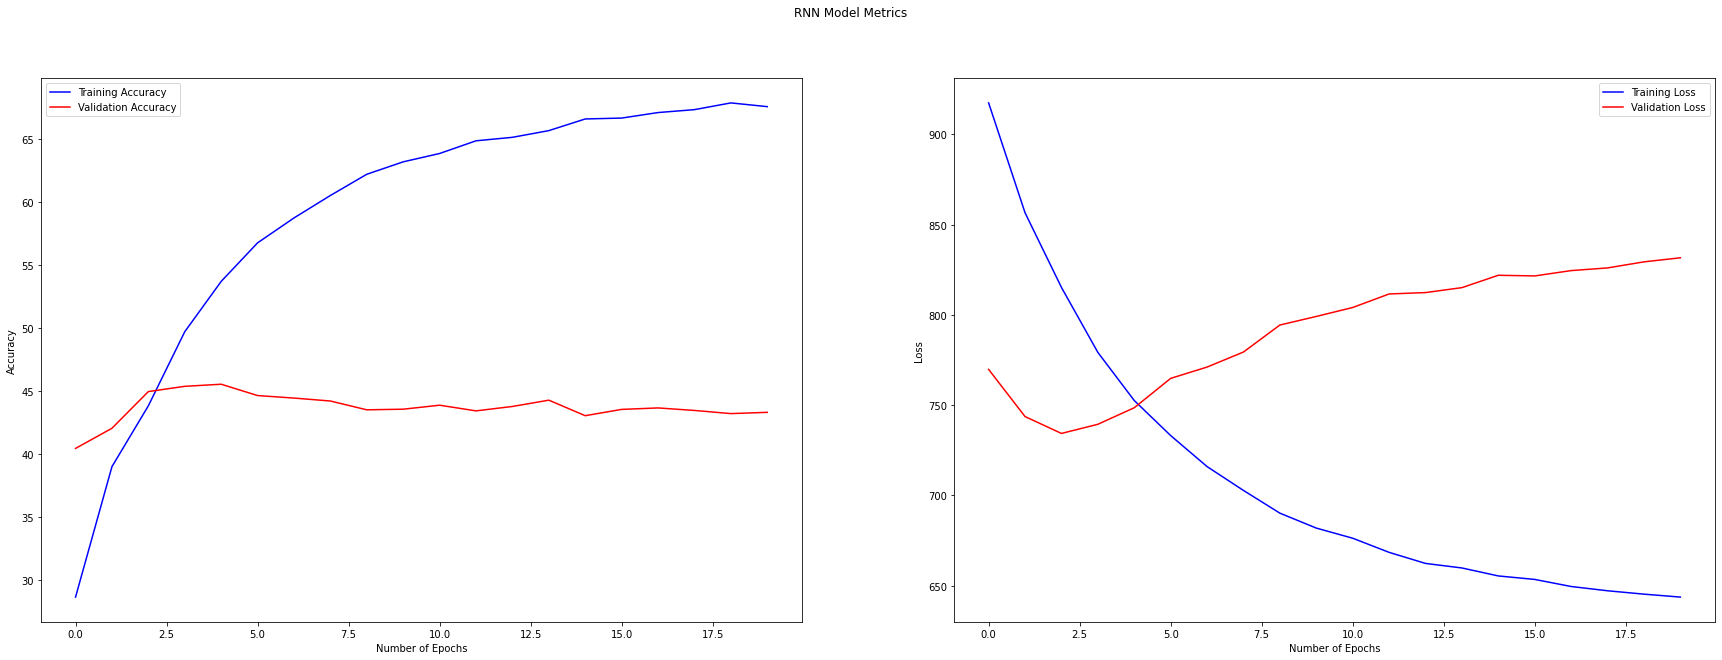

In [ ]:
# Plotting the accuracy and loss of the RNN model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
plt.suptitle('RNN Model Metrics')
ax1.plot(torch.arange(len(rnn_model.train_accuracies)), rnn_model.train_accuracies.to(cpu), 'b-', label='Training Accuracy')
ax1.plot(torch.arange(len(rnn_model.val_accuracies)), rnn_model.val_accuracies.to(cpu), 'r-', label='Validation Accuracy')
ax1.set_xlabel('Number of Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(torch.arange(len(rnn_model.train_losses)), rnn_model.train_losses.to(cpu), 'b-', label='Training Loss')
ax2.plot(torch.arange(len(rnn_model.val_losses)), rnn_model.val_losses.to(cpu), 'r-', label='Validation Loss')
ax2.set_xlabel('Number of Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
plt.show()

## Analysis

From the graphs, we see that:
- the training accuracy increases steadily upto a point while the validation accuracy stagnates at 46%. 
-  the training loss keeps decreasing while the validation loss continues to increase.

1. This trend shows that our model starts to overfit after epoch 5, and hence under-performs on the validation set. However, the validation loss doesn't stabilize and instead continues to increase. **This means that model training has diverged significantly.**

2.We implemented multiple regularization techniques such as dropout in the linear and LSTM layers, more data (scaled from 27k to 64k movies), normalization of gradient, initialization of LSTM weights to a uniform distribution, exponential learning-rate decay, and performed hyperparamater-tuning.

3.**Since the task of genre-prediction using texts doesn't really depend on the sequence of words in the summaries, a bidirectional LSTM maybe more of an overkill. This is because an RNN tries to find the correlation within the sequence of the words in the summaries, which is not as important in our problem, since we are trying to classify the text rather than understand the relationship between consecutive words.**

Hence, it does perform better than our baseline but has several loopholes that can be mitigated with extra resources (increased/complex architecture) and better hyperparameter-tuning

## Conclusion

1. The Convolutional Neural Network model seems to be the best fit for this problem as shown by the model’s accuracy and its aversion towards overfitting.
Some reasons why CNN models work better are:
  - They process the words as morphemes.
  - They consider groups of words in close vicinity.
  - They try to extract features from the summaries in terms of word groups and morpheme groups.
  - This allows the CNN model to better understand the relationship between summaries and their genres.

2. The MLP model is not capable of learning the deeper connections between the words and the summaries, and is, therefore, not as powerful.

3. The RNN tries to find the correlation within the sequence of the words in the summaries, which is not as important in our problem, since we are trying to classify the text rather than understand the relationship between consecutive words.

**Therefore, eventhough both LSTM and CNN perform better than the baseline, we conclude that our CNN proves to be a more robust model.**

## Future Work

- We can increase the architecture of the CNN to extract more features.
- We can increase the vocabulary size of the training set to give higher context to all the neural network models.
- Perform better hyperparameter tuning.
- Increase the training set size to reduce overfitting.

